In [23]:
import sys
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [2]:
CLASSES = ['0', '1']
SPAM_TRAIN_FILE_PATH = '../data/email_spam/spam_train.txt'

In [3]:
############### QUESTION 1 ###############

def read_text_file(file_path):
    """Returns each line of file as a list of strings"""
    
    if not os.path.isfile(file_path):
        print("File {} doesn't exist".format(file_path))
    
    file_lines = []
    
    with open(file_path) as fp:
        for line in fp:
            file_lines.append(line)
    
    return file_lines


def train_val_split_sequential(file_path, ratio):
    """
    Splits a file into training and validation data by a specified ratio
    Train-validation splits are returned as lists of string
    """
    
    data = read_text_file(file_path)
    train_size = int(len(data) * ratio)
    train_data = data[0:train_size]
    val_data = data[train_size:]
    
    return (train_data, val_data)

In [4]:
train_data, val_data = train_val_split_sequential(SPAM_TRAIN_FILE_PATH, 0.8)

Creation of a validation set allows us to tune the hyperparameters of the model to increase the accuracy.
This is something that cannot be done on the test set because ideally the test should should purely be used to report the final performance of the model. Using the test set while training can induce a bias in the model and the model may not generalize well beyond the given datasets.

In [5]:
############### QUESTION 2 ###############

def build_vocab(data, threshold=0):
    """
    Takes input as a list of strings and returns a vocab of distinct words occurring in it.
    Ignores all words occurring less than the threshold.
    """
    
    vocab = {}
    
    for line in data:
        for word in line.split(' '):
            vocab[word] = (1 if word not in vocab else (vocab[word] + 1))
    
    # remove the class names from vocab
    for class_ in CLASSES:
        vocab.pop(class_, None)
    
    # remove all keys with counts below a certain threshold
    if threshold > 0:
        for word in list(vocab.keys()):
            if vocab[word] < threshold:
                vocab.pop(word, None)
    
    return vocab


def transform_doc_to_features(doc, vocab_keys):
    """
    Transforms a single text document into a feature vector.
    The vectorizer is a binary vectorizer i.e. the features takes value 1 if the word is
        present in the text and 0 if the word is absent.
    """
    
    ret_list = []
    doc_class = doc.split(' ')[0]
    doc_words = doc.split(' ')[1:]
    
    ret_list.append(doc_class)
    
    for key in vocab_keys:
        if key in doc_words:
            ret_list.append(1)
        else:
            ret_list.append(0)
    
    return ret_list

def transform_text_to_features(data, master_vocab_keys=[]):
    """
    Transforms text data into feature vectors by building a dictionary if a dictionary is not provided.
    The vectorizer is a binary vectorizer i.e. the features takes value 1 if the word is
        present in the text and 0 if the word is absent.
    Input is a list of strings.
    Output is a dataframe of word features.
    """
    
    if len(master_vocab_keys) == 0:
        vocab = build_vocab(data, 30)
        vocab_keys = list(vocab.keys())
    else:
        vocab_keys = master_vocab_keys
    
    vocab_keys.sort()
    features = ['__target__']
    features.extend(vocab_keys)
    transformed_list = []
    
    for doc in data:
        transformed_list.append(transform_doc_to_features(doc, vocab_keys))
    
    return pd.DataFrame(transformed_list, columns = features), vocab_keys

In [6]:
train_df, vocab_keys = transform_text_to_features(train_data)
val_df, _ = transform_text_to_features(val_data, vocab_keys)

In [48]:
############### QUESTION 3 ###############

def drop_zeros(data):
    train_features = list(data.columns)
    train_features.remove('__target__')
    
    for index, row in data.iterrows():
        x = row[train_features].to_numpy()
        if x.sum() == 0:
            data.drop(index, inplace = True)
    
    return data

def perceptron_train(data):
    """
    Trains a perceptron model on the input dataframe
    """
    
    num_features = len(data.columns)
    w = np.zeros(num_features - 1)
    num_iterations = 0
    num_updates = 0
    
    train_features = list(data.columns)
    train_features.remove('__target__')
    
    data = drop_zeros(data)
    
    error_flag = True
    while error_flag:
        error_flag = False
        for index, row in data.iterrows():
            y = int(row['__target__'])
            y = y * 2 - 1
            x = row[train_features].to_numpy()
            
            if y * np.dot(w, x) <= 0:
                w = w + y * x
                error_flag = True
                num_updates += 1
        
        num_iterations += 1
    
    return (w, num_updates, num_iterations)


def perceptron_test(w, data):
    """
    Tests a trained perceptron model with weights w on a dataset
    Returns the test error [number of misclassified samples]
    """
    
    train_features = list(data.columns)
    train_features.remove('__target__')
    
    test_error = 0
    for index, row in data.iterrows():
        y = int(row['__target__'])
        x = row[train_features].to_numpy()
        
        if (y == 0 and np.dot(w, x) >= 0) or (y == 1 and np.dot(w, x) < 0):
            test_error += 1
    
    test_error /= len(data.index)
    
    return test_error


In [49]:
############### QUESTION 4 ###############

print("learning weights from the Perceptron Algorithm...")
weights, num_mistakes, num_iterations = perceptron_train(train_df)
print("number of mistakes by the Perceptron Algorithm while learning = {}\n".format(num_mistakes))

print("checking the error on the training set...")
training_error = perceptron_test(weights, train_df)
print("number of mistakes the training set after learning = {}\n".format(training_error))

print("testing the Perceptron Algorithm on the validation set...")
validation_error = perceptron_test(weights, val_df)
print("error on the validation set = {}\n".format(validation_error))

learning weights from the Perceptron Algorithm...
number of mistakes by the Perceptron Algorithm while learning = 419

checking the error on the training set...
number of mistakes the training set after learning = 0.0

testing the Perceptron Algorithm on the validation set...
error on the validation set = 0.023



In [21]:
############### QUESTION 5 ###############

def get_top_dict_values(dict_, k, order = 0):
    """
    Sorts a dict and returns the top k elems as a list of tuples (ordered by values)
    order = 0 for ascending, order = 1 for descending
    """
    
    # map the order from {0, 1} to {-1, 1}
    order = order * 2 - 1
    
    d = {k:v for k, v in sorted(dict_.items(), key = lambda item : -order*item[1])}
    ret_list = []
    for x in list(d)[0:(k + 1)]:
        ret_list.append((x, d[x]))
    
    return ret_list

def print_top_dict_values(dict_, k, order = 0):
    """
    Prints the top k elems of the dictionary (ordered by values)
    order = 0 for ascending, order = 1 for descending
    """
    
    for x in get_top_dict_values(dict_, k, order):
        print("{}\t{}".format(x[1], x[0]))

feature_weight_map = dict(zip(vocab_keys, weights))

print("features with the smallest weights")
print_top_dict_values(feature_weight_map, 15, 0)

print("\nfeatures with the largest weights")
print_top_dict_values(feature_weight_map, 15, 1)



features with the smallest weights
-19.0	wrote
-14.0	prefer
-14.0	which
-12.0	inc
-12.0	messag
-12.0	sinc
-12.0	url
-11.0	and
-11.0	copyright
-11.0	i
-11.0	still
-10.0	but
-10.0	date
-10.0	open
-10.0	reduc
-10.0	run

features with the largest weights
16.0	click
16.0	pleas
16.0	remov
16.0	sight
14.0	form
13.0	deathtospamdeathtospamdeathtospam
13.0	market
13.0	offer
13.0	our
12.0	internet
12.0	most
11.0	ad
11.0	below
11.0	further
11.0	guarante
11.0	minut


In [22]:
############### QUESTION 6 ###############

def averaged_perceptron_train(data):
    """
    Trains a perceptron model on the input dataframe
    """
    
    num_features = len(data.columns)
    w = np.zeros(num_features - 1)
    w_avg = np.zeros(num_features - 1)
    num_iterations = 0
    num_updates = 0
    
    train_features = list(data.columns)
    train_features.remove('__target__')
    
    error_flag = True
    while error_flag:
        error_flag = False
        for index, row in data.iterrows():
            y = int(row['__target__'])
            x = row[train_features].to_numpy()
            
            if y == 0 and np.dot(w, x) >= 0:
                w = w - x
                error_flag = True
                num_updates += 1
            elif y == 1 and np.dot(w, x) < 0:
                w = w + x
                error_flag = True
                num_updates += 1
            
            w_avg = w_avg + w
        
        num_iterations += 1
    
    w_avg = w_avg / (len(data.index) * num_iterations)
    
    return (w_avg, num_updates, num_iterations)

In [26]:
############### QUESTION 7 ###############

NUM_TRAIN_SAMPLES = 5000
NUM_ITERATION_LIST = [100, 200, 400, 800, 2000, 4000]
validation_error_list = []
validation_error_list_avg = []

for N in NUM_ITERATION_LIST:
    print("processing iteration " + str(N) + "...")
    train_data_N, val_data_N = train_val_split_sequential(SPAM_TRAIN_FILE_PATH, N / NUM_TRAIN_SAMPLES)
    train_df_N, vocab_keys_N = transform_text_to_features(train_data_N)
    val_df_N, _ = transform_text_to_features(val_data_N, vocab_keys_N)
    
    print("running simple perceptron...")
    weights_N, num_mistakes_N, num_iterations_N = perceptron_train(train_df_N)
    validation_error_N = perceptron_test(weights_N, val_df_N)
    validation_error_list.append(validation_error_N)
    
    print("num_mistakes = " + str(num_mistakes_N))
    print("num_iterations = " + str(num_iterations_N))
    print("validation_error = " + str(validation_error_N))
    print("\n")
    
    print("running averaged perceptron...")
    weights_N, num_mistakes_N, num_iterations_N = averaged_perceptron_train(train_df_N)
    validation_error_N = perceptron_test(weights_N, val_df_N)
    validation_error_list_avg.append(validation_error_N)
    
    print("num_mistakes = " + str(num_mistakes_N))
    print("num_iterations = " + str(num_iterations_N))
    print("validation_error = " + str(validation_error_N))
    print("\n")
    print("------------------------------------------------------------------------------------------")
    print("\n")

processing iteration 100...
running simple perceptron...
num_mistakes = 45
num_iterations = 6
validation_error = 0.11408163265306122


running averaged perceptron...
num_mistakes = 45
num_iterations = 6
validation_error = 0.11285714285714285


------------------------------------------------------------------------------------------


processing iteration 200...
running simple perceptron...
num_mistakes = 78
num_iterations = 10
validation_error = 0.069375


running averaged perceptron...
num_mistakes = 78
num_iterations = 10
validation_error = 0.0775


------------------------------------------------------------------------------------------


processing iteration 400...
running simple perceptron...
num_mistakes = 100
num_iterations = 7
validation_error = 0.051956521739130436


running averaged perceptron...
num_mistakes = 100
num_iterations = 7
validation_error = 0.050217391304347825


------------------------------------------------------------------------------------------


process

Text(0, 0.5, 'validation error')

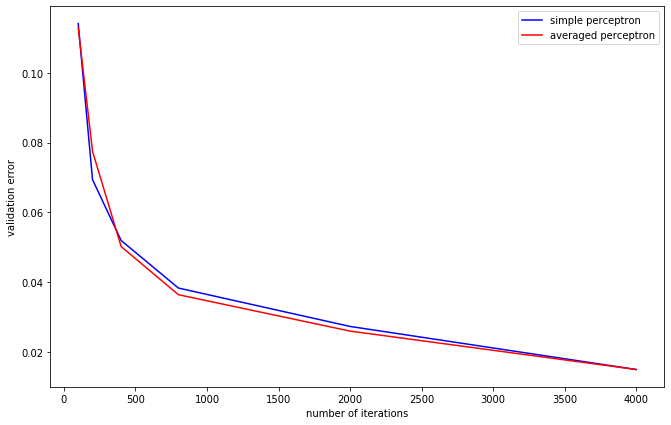

In [44]:

fig, ax = plt.subplots(figsize = (11, 7))

ax.plot(NUM_ITERATION_LIST, validation_error_list, color = 'blue', label = 'simple perceptron')
ax.plot(NUM_ITERATION_LIST, validation_error_list_avg, color = 'red', label = 'averaged perceptron')
ax.legend()
plt.xlabel('number of iterations')
plt.ylabel('validation error')
